In [1]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [3]:
def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

In [4]:
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 number_steps_to_update_target_network=100,mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
        self.q_target = self.q_eval
        self.number_steps_to_update_target_network = number_steps_to_update_target_network
        self.step_count_number=0

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            q_next = self.q_target.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)
            self.step_count_number+=1
            if(self.step_count_number == self.number_steps_to_update_target_network):
              self.q_target = self.q_eval
              self.step_count_number = 0
            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [5]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [6]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym

     |████████████████████████████████| 448 kB 4.1 MB/s 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode:  0 score: -275.02  average score -275.02
episode:  1 score: -79.36  average score -177.19
episode:  2 score: -278.95  average score -211.11
episode:  3 score: -177.13  average score -202.62
episode:  4 score: -271.84  average score -216.46
episode:  5 score: -152.44  average score -205.79
episode:  6 score: -289.41  average score -217.74
episode:  7 score: -142.58  average score -208.34
episode:  8 score: -67.20  average score -192.66
episode:  9 score: -288.27  average score -202.22
episode:  10 score: -239.28  average score -205.59
episode:  11 score: -244.94  average score -208.87
episode:  12 score: -102.56  average score -200.69
episode:  13 score: -108.05  average score -194.07
episode:  14 score: -36.71  average score -183.58
episode:  15 score: -92.88  average score -177.91
episode:  16 score: -101.56  average score -173.42
episode:  17 score: -82.27  average score -168.36
episode:  18 score: -254.29  average score -172.88
episode:  19 score: -50.42  average score -166

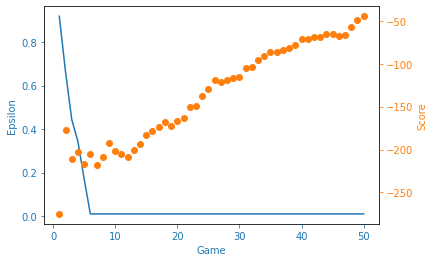

In [7]:
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    lr = 0.0005
    n_games = 50
    agent = Agent(gamma=0.99, epsilon=1.0, alpha=lr, input_dims=8,
                  n_actions=4, mem_size=1000000, batch_size=64, epsilon_end=0.01)

    #agent.load_model()
    scores = []
    eps_history = []

    #env = wrappers.Monitor(env, "tmp/lunar-lander-6",
    #                         video_callable=lambda episode_id: True, force=True)

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)

        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_model()

    filename = 'lunarlander.png'

    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)